In [5]:
# I have an installable package now
# 
# pip install -e '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ephys_analysis import funcs_sorting as sort
from ephys_analysis import funcs_human_characterisation as hcf
from ephys_analysis import funcs_plotting_raw_traces as plotting_funcs
from ephys_analysis import funcs_con_screen as con_param
from ephys_analysis import funcs_plot_intrinsic_props as plot_intr

# this is only for 11.16 because the excel can't be open normally for whatever reason
        
def get_OP_metadata(human_dir, OP, patcher, path_wd):
        
    work_dir = sort.get_work_dir(human_dir, OP, patcher)
    file_list = sort.get_sorted_file_list(work_dir)
    filenames = sort.get_abf_files(file_list)
    jsons= sort.get_json_files(file_list)

    df_rec = pd.read_excel(path_wd, header=1)

    slice_indx, def_slice_names, indices_dict = sort.sort_protocol_names(df_rec, path_wd, 'old')

    if OP + '_indices_dict.json' in jsons:
        indices_dict = sort.from_json(work_dir, OP, '_indices_dict.json')
    else:
        sort.to_json(work_dir, OP, '_indices_dict.json', indices_dict)

    slice_names = sort.fix_slice_names(def_slice_names, slice_indx)
    return work_dir, filenames, indices_dict, slice_names

/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/detect_peaks.py:11: UserWarning: A newest version is available at https://pypi.org/project/detecta/
  warnings.warn('A newest version is available at https://pypi.org/project/detecta/')


In [14]:
#      manual inputs
human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/mouse/'

OP = '2023.11.16_CA1-sub' # name of the data folder
tissue_source = ''
inj = 'full'
age = ''
patcher = ''

# here you have to enter the date and time of the recording mаnually
# in the comments are the possible entries 
if OP == '2023.11.13_CA1_subiculum':
    active_chans_meta = [{'OP_time': ["2023-11-13 08:44:00"], # 13.11 8:44, 14.11 08:31, 16.11 - 09:16
                        'slices' :['S1', 'S2', 'S3'],
                        'vc_files': [0, 9, 20],                      
                        'active_chans': [[1, 5, 6, 8],
                                        [2, 6, 7, 8],
                                        [6, 7, 8]]}]
    work_dir, filenames, indices_dict, slice_names = sort.get_OP_metadata(human_dir, OP, patcher, 'old')

if OP == '2023.11.14_CA1_subiculum':
    active_chans_meta = [{'OP_time': ["2023-11-14 08:31:00"], # 13.11 8:44, 14.11 08:31, 16.11 - 09:16
                        'slices' : ['S1', 'S1_2','S2', 'S2_2'],
                        'vc_files': [0, 8, 16, 28],                      
                        'active_chans': [[2, 4, 7, 8],
                                        [1, 2, 8],
                                        [1, 2, 8],
                                        [1, 2, 6]]}]
    work_dir, filenames, indices_dict, slice_names = sort.get_OP_metadata(human_dir, OP, patcher, 'old')

if OP == '2023.11.16_CA1-sub':
    active_chans_meta = [{'OP_time': ["2023-11-16 09:16:00"], # 13.11 8:44, 14.11 08:31, 16.11 - 09:16
                        'slices' :['S1', 'S2', 'S2_2', 'S3','S4'],
                        'vc_files': [0, 10, 20, 41],                      
                        'active_chans': [[7, 8],
                                        [4, 6, 7, 8],
                                        [1, 2, 4, 7, 8],
                                        [],
                                        [4, 7, 8]]}]
    work_dir, filenames, indices_dict, slice_names = get_OP_metadata(human_dir, OP, patcher, 
                                                                     human_dir + OP + '/' + 'connectivity_labbook_template_CA1_sub.xlsx')

In [15]:
# #creating a dir to save plots and data_tables (if not existing)
dir_plots = sort.make_dir_if_not_existing(work_dir, 'plots')
sort.make_dir_if_not_existing(work_dir, 'data_tables')

#      check if the traces dir is empty and only then plot the middle sweep for each filename
sort.plot_trace_if_not_done(work_dir, dir_plots, filenames)
cortex_out_time = sort.get_datetime_from_input(active_chans_meta[0]['OP_time'][0])
                                                                                            
# creating the dataframe
df_OP = pd.DataFrame(columns=['filename', 'slice', 'cell_ch',
                            'hrs_after_slicing', 'Rs', 'Rin', 'resting_potential', 'max_spikes',
                            'Rheobase', 'AP_heigth', 'TH', 'max_depol', 'max_repol', 'membra_time_constant_tau',
                            'capacitance', 'AP_halfwidth', 'cell_type', 'inputs', 'AP_in_input', 'comment'])

for i in range(len(indices_dict['vc'])):
    vc = indices_dict['vc'][i]
    vm = indices_dict['resting'][i]
    char = indices_dict['characterization'][i]

    slic = slice_names[vc]

    filename_vc = work_dir + filenames[vc]
    filename_vm = work_dir + filenames[vm]
    filename_char = work_dir + filenames[char]

    time_after_op = sort.get_time_after_OP(filename_char, cortex_out_time)

    active_channels = active_chans_meta[0]['active_chans'][i]

    cell_IDs = hcf.get_cell_IDs(filename_char, slic, active_channels)
    
    # time_after_op = sort.get_time_after_OP()
    Rs, Rin = hcf.get_access_resistance(filename_vc, active_channels)
    RMPs = hcf.get_RMP(filename_vm, active_channels)
                                                                             
    params1_df = pd.DataFrame({'filename': filenames[char], 'slice' : slic, \
                                   'cell_ch': active_channels, 'hrs_after_OP' : time_after_op, \
                                    'cell_ID':cell_IDs ,'Rs' : Rs, 'Rin': Rin, 'resting_potential': RMPs})
        
    inj = hcf.get_inj_current_steps(filename_char)
    charact_params = hcf.all_chracterization_params(filename_char, active_channels, inj)
    df_char = pd.DataFrame.from_dict(charact_params)
    
    df_to_add = pd.concat([params1_df, df_char], axis=1)
    df_OP = pd.concat([df_OP.loc[:], df_to_add]).reset_index(drop=True)
         
     # plotting function=
    plotting_funcs.plot_vc_holding(filename_vc, active_channels)
    plotting_funcs.plots_for_charact_file(filename_char, active_channels, inj) 
                     
OPs = pd.Series(OP).repeat(len(df_OP))
researcher = pd.Series('Verji').repeat(len(df_OP))              
series_df = pd.DataFrame({'OP': OPs, 'patcher': researcher}).reset_index(drop=True)

df_intrinsic = pd.concat([series_df, df_OP], axis=1)
df_intrinsic.to_excel(work_dir + 'data_tables/' + OP +
                      '_Intrinsic_and_synaptic_properties.xlsx', index=False)
# df_intrinsic.to_csv(work_dir + 'data_tables/' + OP[:-1] + '_Intrinsic_and_synaptic_properties.csv')

print('Intrinsic properties DataFrame for  ' + OP +
      ' saved successfully. ' + '\n' + 'Exclude recordings if necessary.')

skipping plotting
MAX number of AP = 1 for Ch7


/var/folders/5y/f01m99kn5tx3chk04wp6sc440000gn/T/ipykernel_83080/723979107.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_OP = pd.concat([df_OP.loc[:], df_to_add]).reset_index(drop=True)


MAX number of AP = 1 for Ch7
MAX number of AP = 1 for Ch7


/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_human_characterisation.py:417: RankWarning: Polyfit may be poorly conditioned
  model_rise = np.polyfit(x, y, 1)
/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_plotting_raw_traces.py:245: RankWarning: Polyfit may be poorly conditioned
  IOfit = np.polyfit(spike_counts_all[n][first_spikes[n]:,0], spike_counts_all[n][first_spikes[n]:,1],1)


MAX number of AP = 1 for Ch7


/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_human_characterisation.py:417: RankWarning: Polyfit may be poorly conditioned
  model_rise = np.polyfit(x, y, 1)
/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_human_characterisation.py:417: RankWarning: Polyfit may be poorly conditioned
  model_rise = np.polyfit(x, y, 1)
/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_human_characterisation.py:417: RankWarning: Polyfit may be poorly conditioned
  model_rise = np.polyfit(x, y, 1)
/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/src/ephys_analysis/funcs_human_characterisation.py:417: RankWarning: Polyfit may be poorly conditioned
  model_rise = np.polyfit(x, y, 1)


MAX number of AP = 1 for Ch7
MAX number of AP = 1 for Ch7
MAX number of AP = 1 for Ch7
Intrinsic properties DataFrame for  2023.11.16_CA1-sub saved successfully. 
Exclude recordings if necessary.


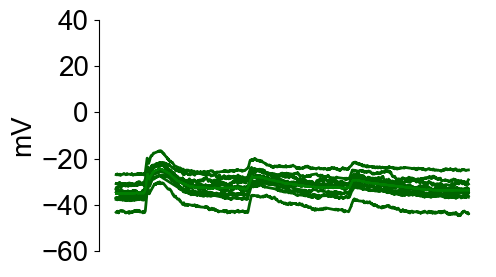

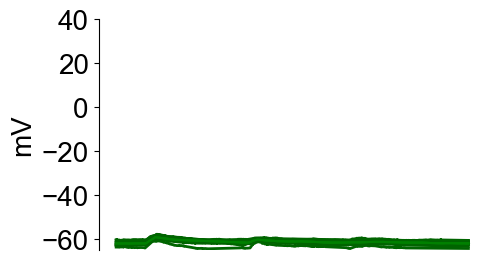

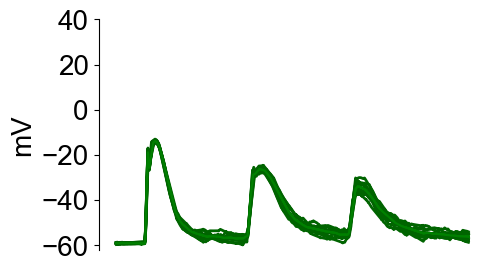

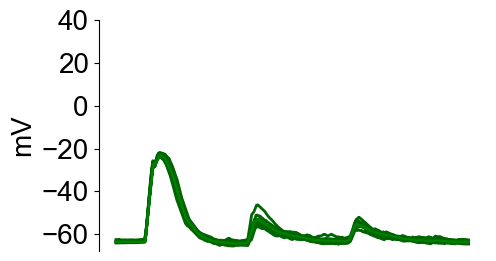

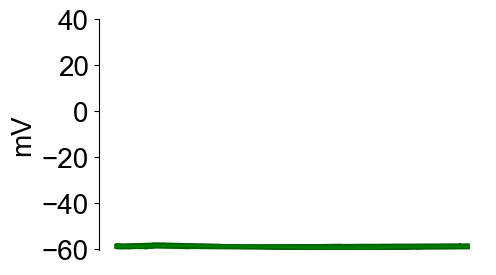

In [20]:
#      connectivity screen analysis
# con_sccreen_connected_chans = active_chans_meta[1]

# for k, slic in enumerate(con_sccreen_connected_chans['con_screen_IC_file_indices']):
#     post_cells = con_sccreen_connected_chans['post_chans_VC'][k]
#     for cell in post_cells:
#         fn = work_dir + filenames[slic]
#         plotting_funcs.plot_trace(fn, 5, cell)


#      the following is a quick script to get a plot of the characterization and the input file

# fn_indx = 22
# active_channels = [1]
#      swp = 9
channels = [1,2,4,  7, 8]
indx_input_screen_fn = 32
slic = 'S2_2'
#      plotting_funcs.plot_trace(work_dir + filenames[fn_indx], swp, chan)

fn_input_screen = work_dir + filenames[indx_input_screen_fn]
con_screen_data = hcf.load_traces(fn_input_screen)

for chan in channels:
    chan_name = 'Ch' + str(chan)
    pre_sig = con_screen_data[chan_name][0]
    vmO = np.mean(pre_sig, axis=1)   

    fig, ax = plt.subplots(1, 1, figsize = (5, 3))
    for i in range(np.shape(pre_sig)[1]):
        ax.plot(pre_sig[10_000:17_000, i])

        ax.plot(vmO[10_000:17_000], c='green', alpha=1, lw=1.5, label='average input in TTX')
        #  ax.set_title(filenames[indx_input_screen_fn] + ' ' + chan_name)
        # ax.set_axis_off()
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([-60, -40, -20, 0, 20, 40])
        ax.set_ylabel('mV')
        #  fig.legend()
        #  plt.savefig('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/mouse/ca1-sub-channorhodopsin_mice/Calb-CreSubiculum/inputs/legend_2' + '.jpg')
        # plt.savefig('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/mouse/ca1-sub-channorhodopsin_mice/Calb-CreSubiculum/inputs/TTX_4AP_fn_' + str(indx_input_screen_fn) + '_' +slic + 'Ch.' + str(chan) + '.jpg')
        #     plt.savefig(dest_dir + data_type + 'I_O_curve.svg', \
         #        format = 'svg', bbox_inches = 'tight', dpi = 1000)

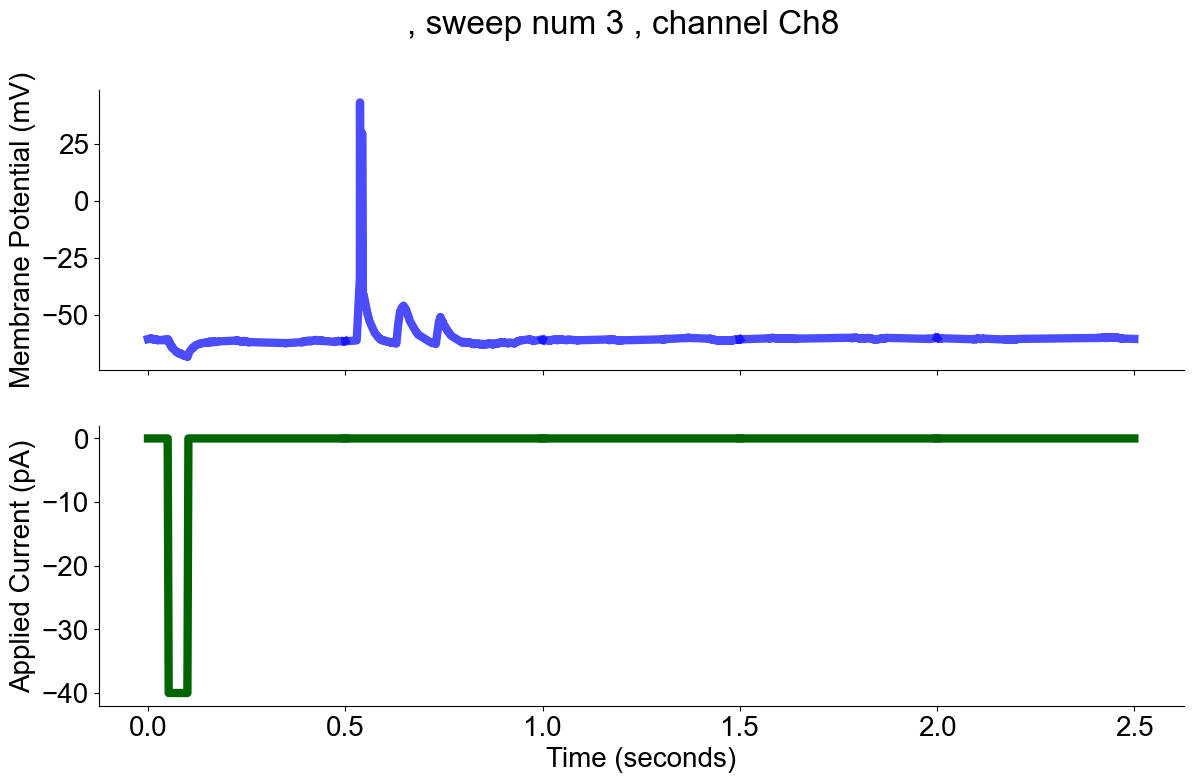

In [ ]:
from ephys_analysis import funcs_plotting_raw_traces as pl_raw

fn = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/mouse/2023.11.16_CA1-sub/23n16024.abf/'
# pl_raw.plot_trace(fn, 3, 8, save_dir = None)